In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error,mean_absolute_error
path = "Results/final_results/electricity/electricity_ip_336_op_168_nhead_4_mask_1_options_all_mean_+full_mask_roc_date/electricity/"
preds = np.load(path+'trans-nll-ar_pred_mu.npy')
inputs = np.load(path+'inputs.npy')
trues = np.load(path+'targets.npy')
#preds = preds.reshape(-1, preds.shape[-2], preds.shape[-1])
#trues = trues.reshape(-1, preds.shape[-2], preds.shape[-1])
# [samples, pred_len, dimensions]
print(preds.shape, trues.shape, inputs.shape)

print("mse : ",mean_squared_error(trues.squeeze(),preds.squeeze()),"mae: ",mean_absolute_error(trues.squeeze(),preds.squeeze()))

(54, 168, 1) (54, 168, 1) (54, 336, 1)
mse :  7809.1025 mae:  65.33611


In [12]:
# x = preds.reshape(54,13,-1,1)
# preds = x.mean(axis=1)
# preds.shape
# x = trues.reshape(54,13,-1,1)
# trues = x.mean(axis=1)
# trues.shape

# print("mse : ",mean_squared_error(trues.squeeze(),preds.squeeze()),"mae: ",mean_absolute_error(trues.squeeze(),preds.squeeze()))

<ipython-input-2-15ad79f1826a>:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


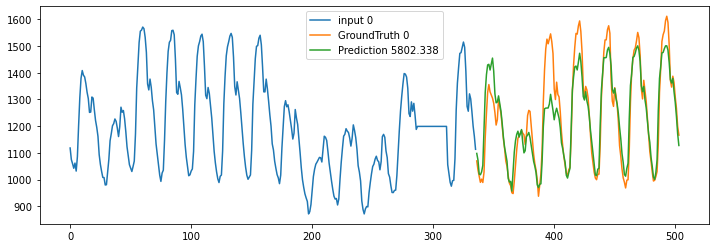

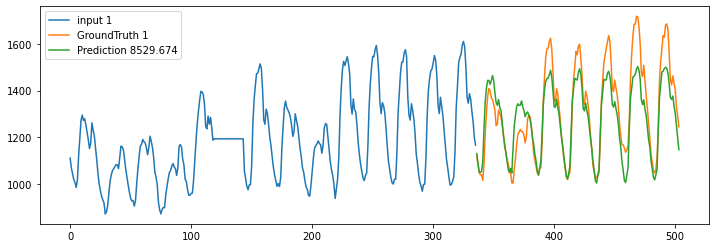

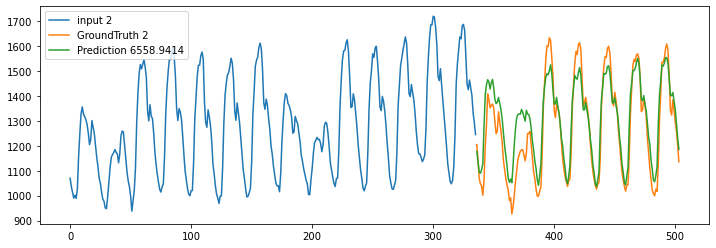

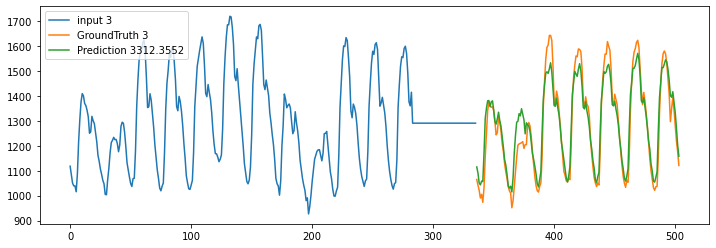

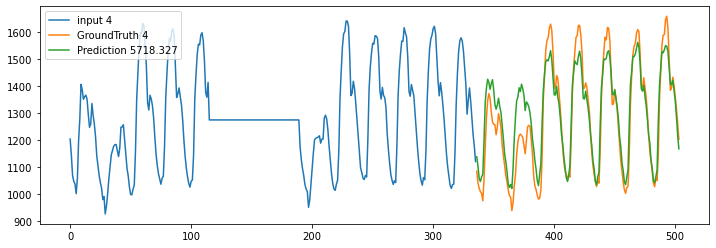

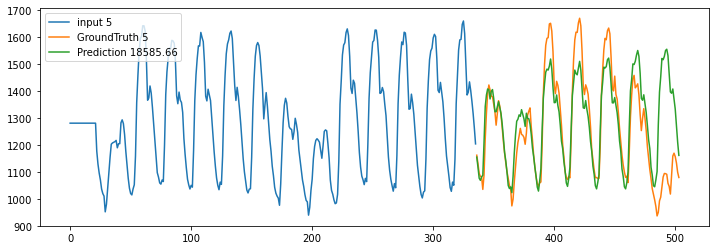

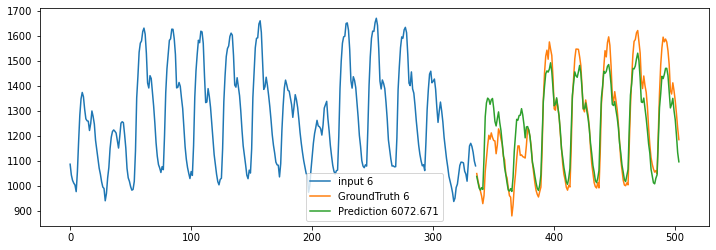

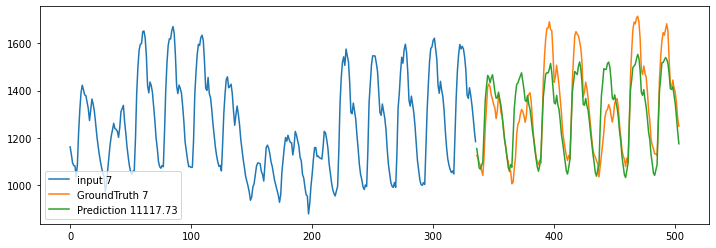

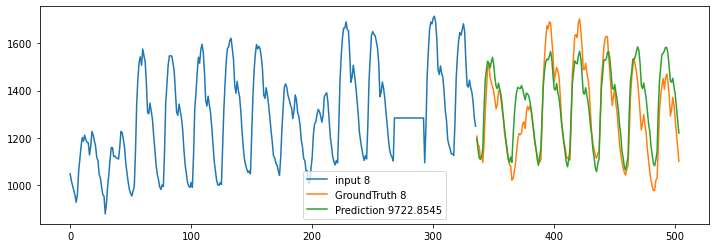

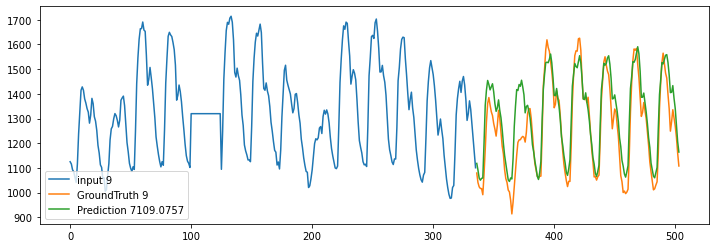

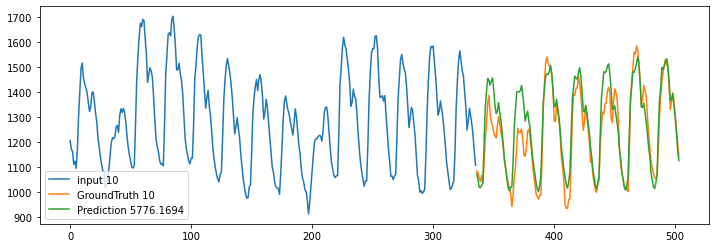

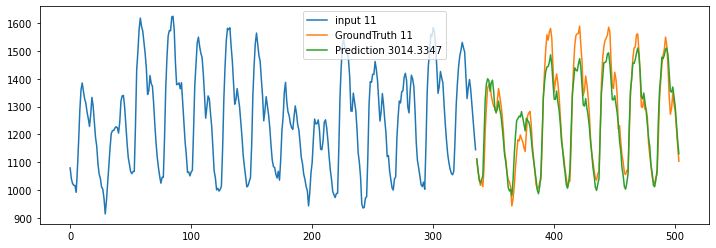

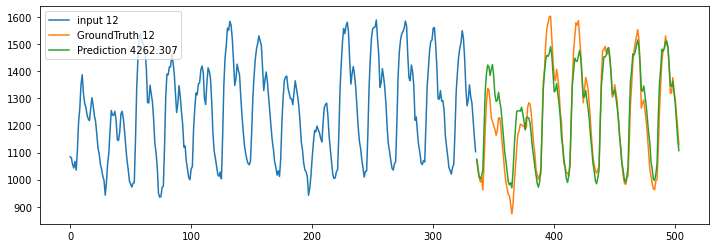

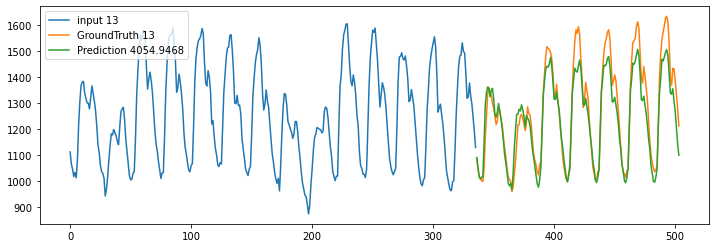

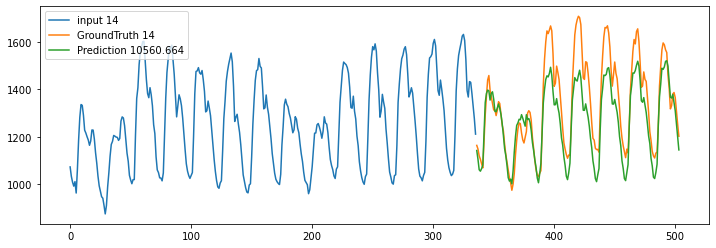

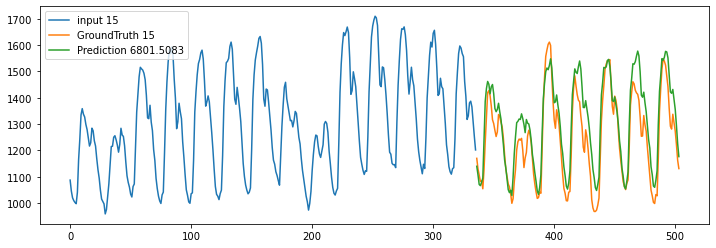

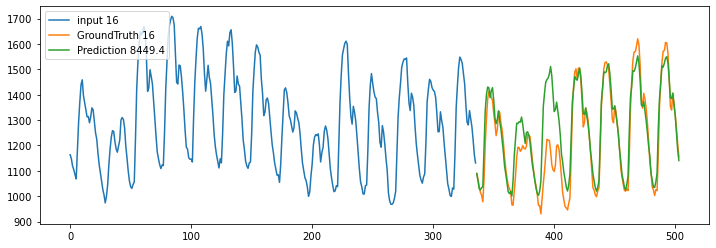

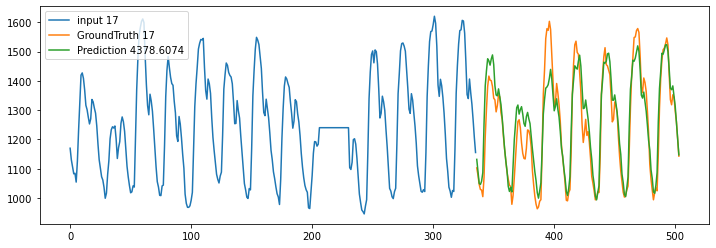

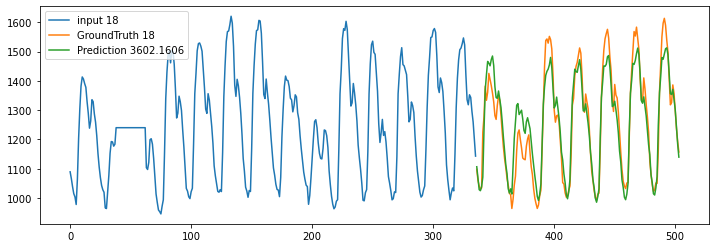

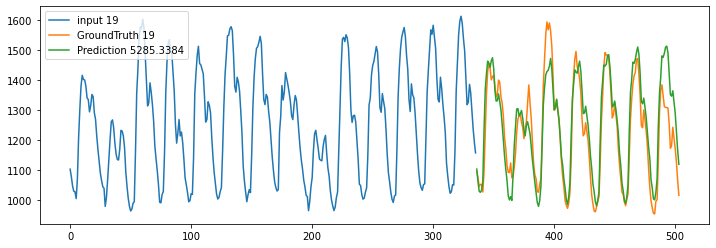

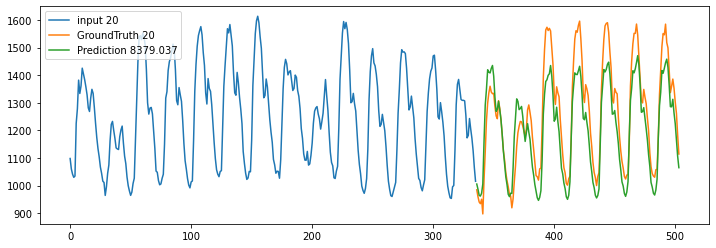

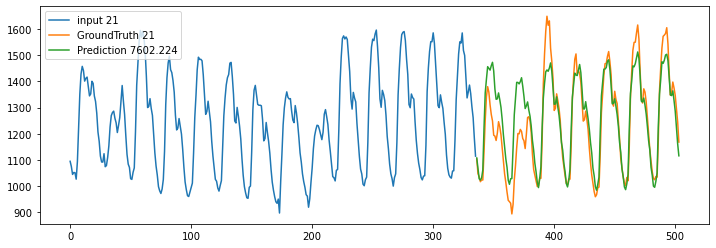

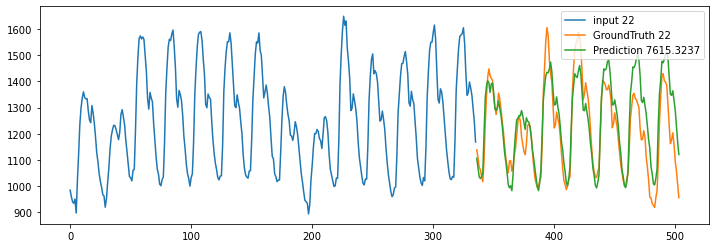

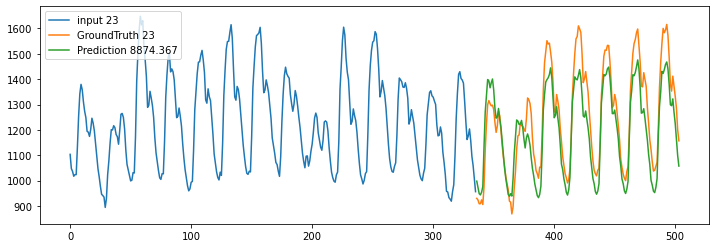

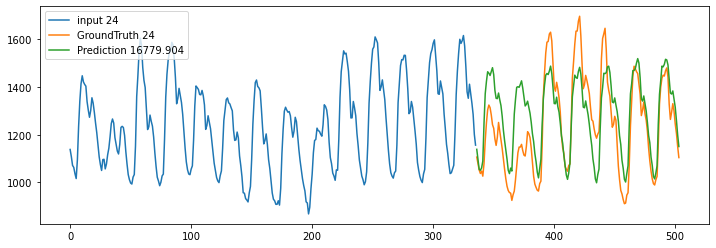

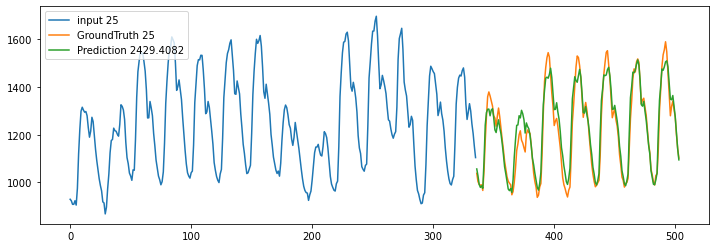

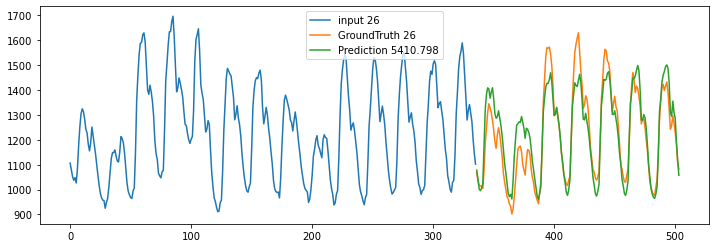

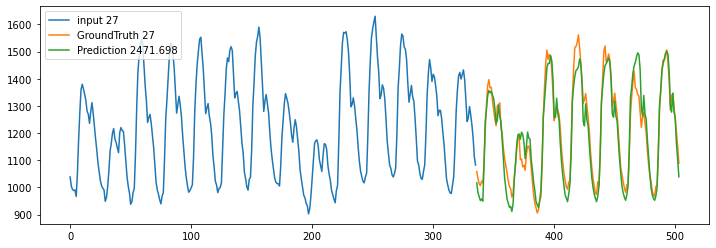

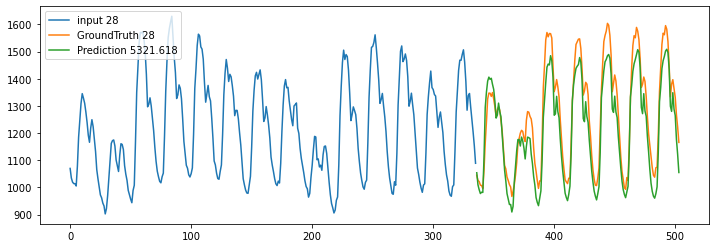

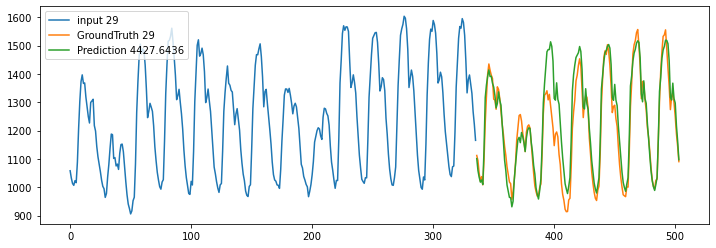

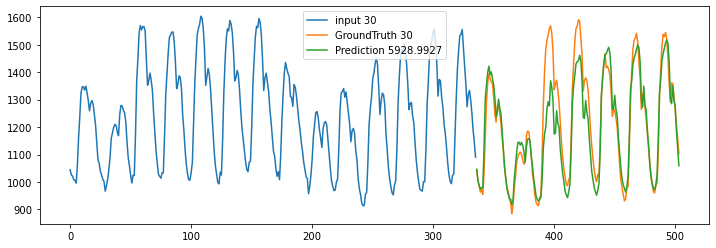

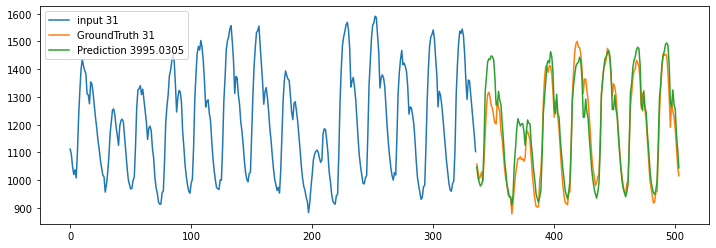

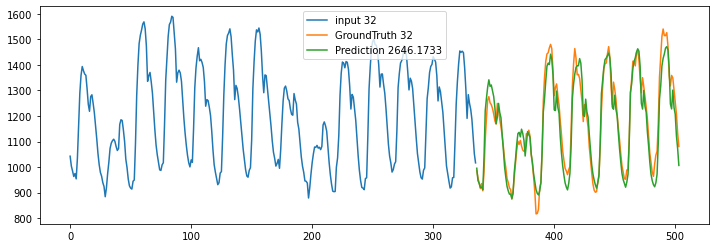

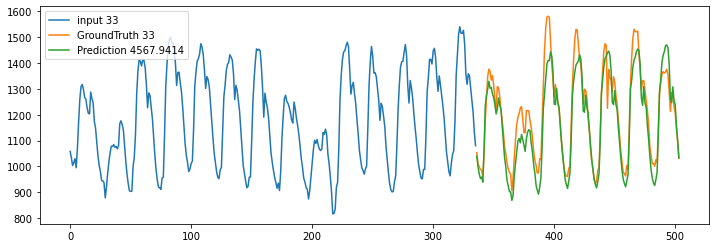

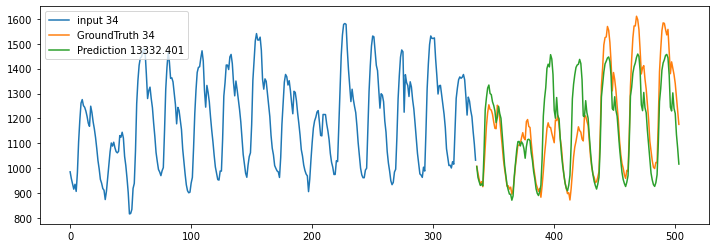

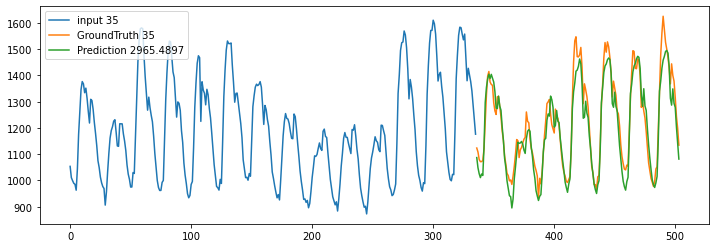

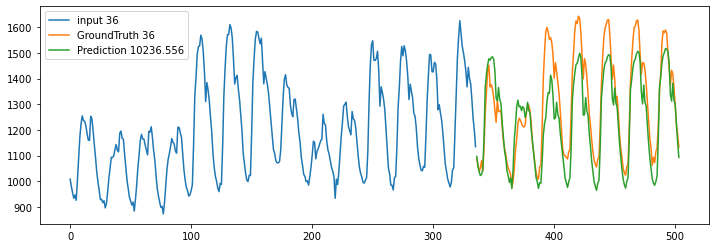

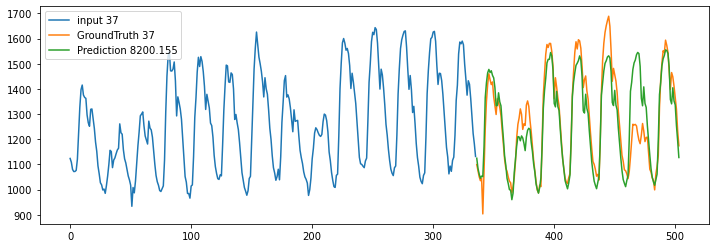

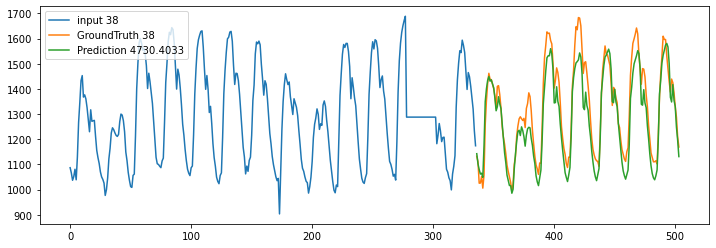

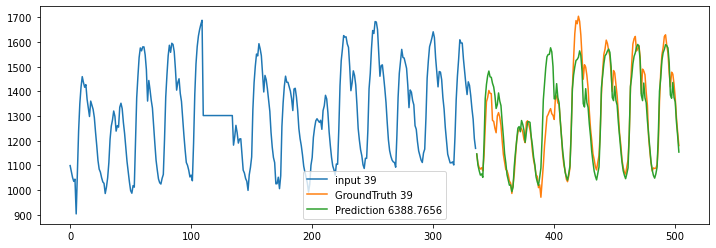

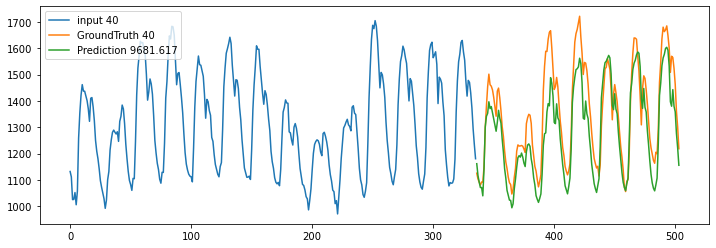

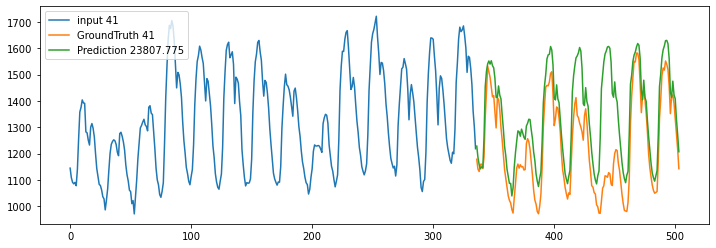

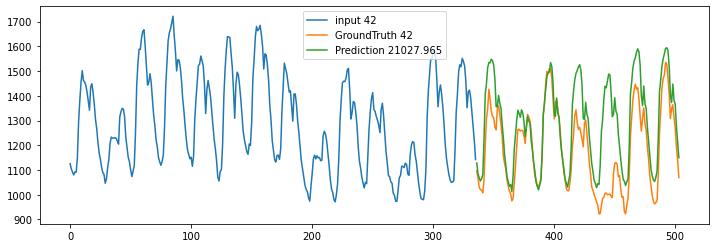

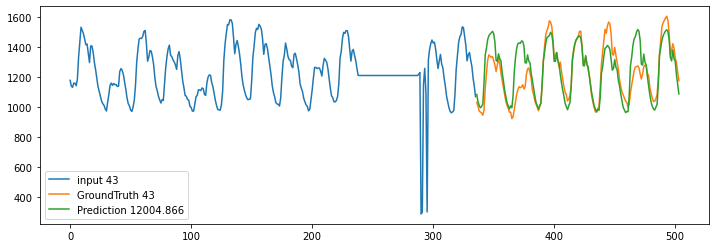

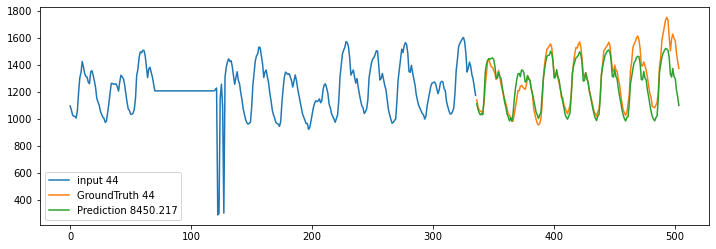

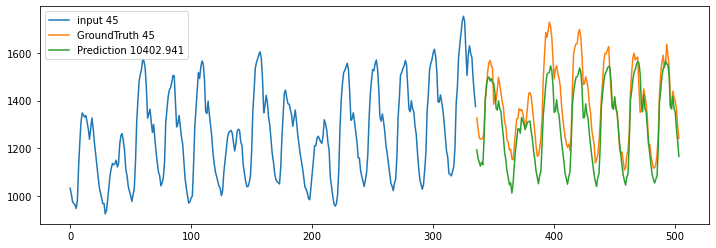

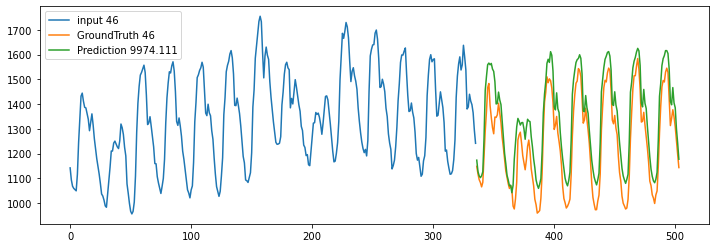

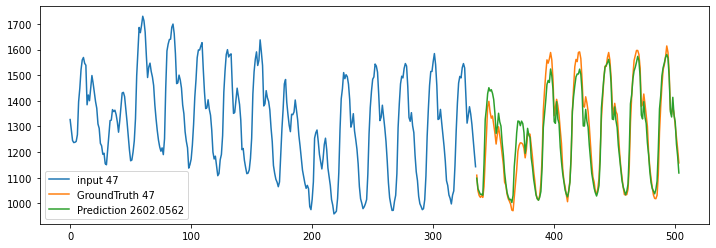

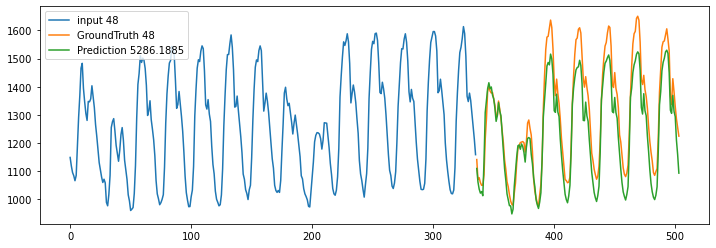

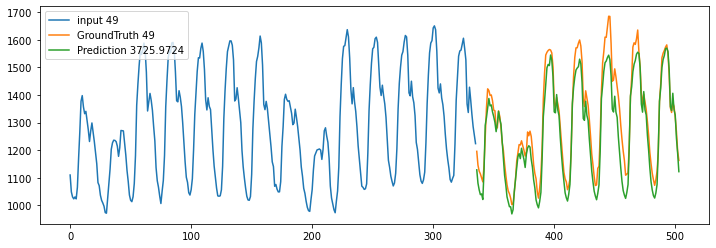

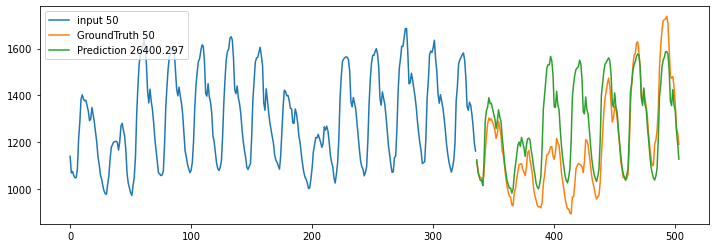

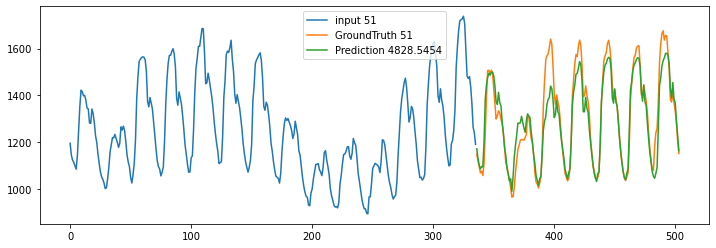

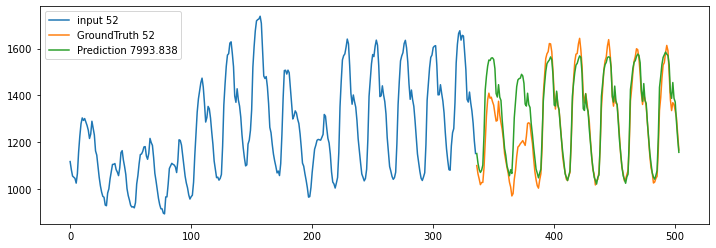

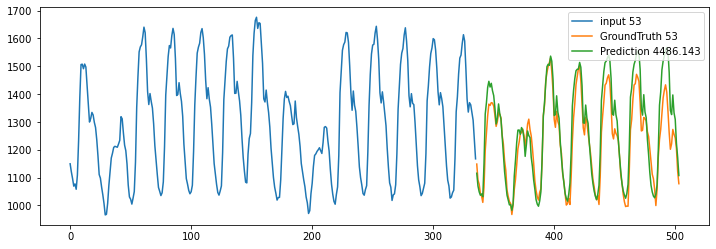

In [2]:
plt.rcParams['figure.figsize'] = (12,4)
x = np.arange(inputs.shape[1]+preds.shape[1])
a = inputs.shape[1]
inp = min(inputs.shape[0],100)

for i in range(inp):
    plt.figure()
    c =i 
    plt.plot(x[:a],inputs[c],label='input '+str(c))
    plt.plot(x[a:],trues[c,:,0], label='GroundTruth '+str(c))
    #for i in range(1):

    plt.plot(x[a:],preds[c,:,0], label='Prediction '+str(mean_squared_error(preds[c,:,0],trues[c,:,0])))
    
    plt.legend()
    # fig = plt.figure()
    # plt.savefig("images/trans-mse_test_"+str(i)+".png")
    
    # plt.show()

In [28]:
plt.rcParams['figure.figsize'] = (25,4)
DATA_DIRS = "/mnt/a99/d0/sandy/Forecasting/"
N_output = 168
df = pd.read_csv(DATA_DIRS+'data/energy-anomaly-detection/train.csv')

df = df[df['building_id']==966].interpolate(limit_direction='both',method='linear')
data = df[['meter_reading']].to_numpy()
# # set_trace()
# data_mask = df[['anomaly']].to_numpy().T

df = pd.read_csv(DATA_DIRS+'data/energy-anomaly-detection/energy_injected_reduced.csv')
data_inj = df[['meter_reading']].to_numpy()
data_mask = df[['anomaly']].to_numpy()


#data = np.expand_dims(data, axis=-1)
# test_data = np.load(os.path.join(DATA_DIRS,"data","energy-anomaly-detection","mask_energy.npy"))
test_data = np.load(os.path.join(DATA_DIRS,"data","energy","energy_mask_iqr.npy"))
test_l = len(test_data)
# data_mask = np.zeros_like(data,dtype=float)
n = data.shape[1]
units = n//N_output
dev_len = int(0.2*units) * N_output
test_len = int(0.2*units) * N_output
train_len = n - dev_len - test_len
# set_trace()

### generated masking
units_l = n//50
dev_len_l = int(0.2*units_l) * 50
test_len_l = int(0.2*units_l) * 50
train_len_l = n - dev_len_l - test_len_l
# set_trace()


### generated masking
# data_mask[...,train_len_l+dev_len_l-N_input:train_len_l+dev_len_l-N_input+test_l] = test_data 
data_mask[250:250+test_l]=test_data.reshape(-1,1)


ValueError: could not broadcast input array from shape (8525,1) into shape (8516,1)

In [30]:
data_mask.shape,test_l+200

((8766, 1), 8725)

In [27]:
import plotly.express as px
import plotly.graph_objects as go

fig = go.Figure()

fig.add_trace(
    go.Scatter(
        x = list(range(len(data_inj))),
        y=data_inj.squeeze()
    ))

fig.add_trace(
    go.Scatter(
        x = list(range(len(data_inj))),
        y=data_mask.squeeze()*500
    ))

fig.show()

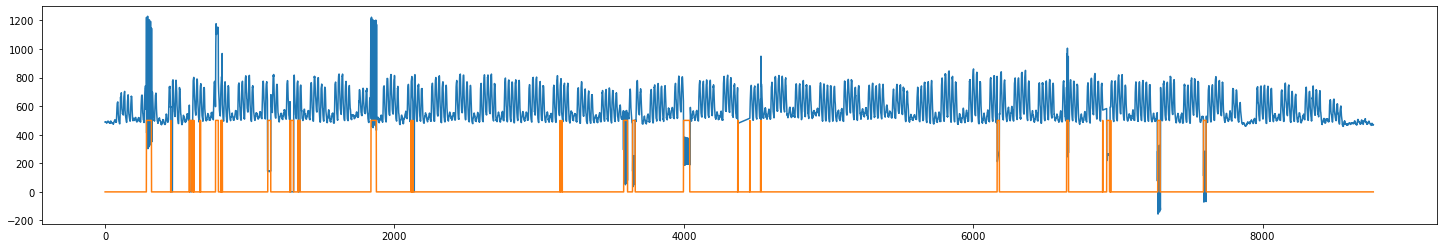

In [11]:
plt.plot(data_inj)
plt.plot(data_mask*500)

In [ ]:
test_data = np.load(os.path.join(DATA_DIRS,"Outliers","Outlier","data","new_masked.npy"))
data_mask[...,train_len+dev_len-N_output:-N_output] = test_data
plt.plot(data_inj[0,:])
# plt.plot(np.array(test_data).reshape(-1,)*1000)
plt.plot(data_mask[0,:]*1000,label="new_mask")
plt.legend()
plt.show()


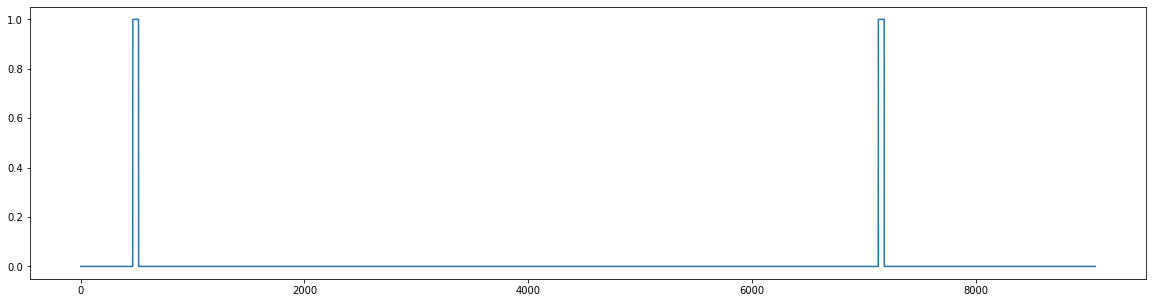

In [16]:
plt.plot(data_mask[-test_len:])

In [7]:
DATA_DIRS = "/mnt/a99/d0/sandy/Forecasting/"
df = pd.read_csv(DATA_DIRS+'data/energy-anomaly-detection/train.csv')

df = df[df['building_id']==966].interpolate(limit_direction='both',method='linear')
data = df[['meter_reading']].to_numpy()
# # set_trace()
# data_mask = df[['anomaly']].to_numpy().T

df = pd.read_csv(DATA_DIRS+'data/energy-anomaly-detection/energy_injected_5.csv')
data_inj = df[['meter_reading']].to_numpy() 
data_mask = df[['anomaly']].to_numpy().T

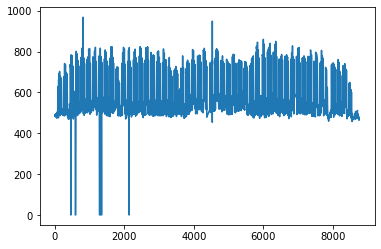

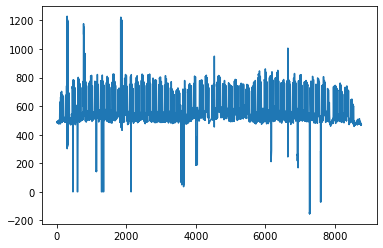

In [11]:
plt.plot(data)
plt.show()
plt.plot(data_inj)
plt.show()

In [182]:
# !python roc_create.py
import os
import numpy as np
import pandas as pd
import random
import re
import json
from pdb import set_trace
from sklearn.metrics import roc_curve, auc
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix
from sklearn import metrics, datasets


class NpEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        if isinstance(obj, np.floating):
            return float(obj)
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        return json.JSONEncoder.default(self, obj)
DATA_DIRS = '/mnt/a99/d0/sandy/Forecasting/'


df_inject   = pd.read_csv(
    os.path.join(DATA_DIRS, 'data', 'electricity_load_forecasting_panama', '2_percent_electricity.csv')
)
# df_inject   = pd.read_csv(
#     os.path.join(DATA_DIRS, 'data', 'electricity_load_forecasting_panama', 'electricity_high_amp_train_low_amp_test.csv')
# )
filename = "electricity"
data_mask = df_inject['label'].to_numpy()  #### original anomalies
n = (1903 + 1) * 24 # Select first n=1904*24 entries because of non-stationarity in the data after first n values
data_mask = data_mask[:n]
test_data = np.load(os.path.join(DATA_DIRS,'data','electricity',"electricity_mask_roc.npy"))
test_l = len(test_data)
fpr, tpr, thresholds = roc_curve(data_mask[200:200+test_l], test_data)
score = metrics.auc(fpr, tpr)
cm = confusion_matrix(data_mask[...,200:200+test_l].reshape(-1,), test_data)
x = list(cm.ravel())
dic = dict({'fpr':fpr,'tpr':tpr,'threshold':thresholds,"score":score,'cm':x})

json_obj = json.dumps(dic,indent=8,cls=NpEncoder)
with open(f"Results/{filename}_roc.json",'w+') as files:
    files.write(json_obj)
